In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

# 1. PROBLEM STATEMENT
---
## ALZHEIMER'S DISEASE

* [Alzheimer's disease (AD)](https://en.wikipedia.org/wiki/Alzheimer%27s_disease) is a neurodegenerative disorder of uncertain cause and pathogenesis that primarily affects older adults and is the most common cause of dementia.
* The earliest clinical manifestation of AD is selective memory impairment and while treatments are available to ameliorate some symptoms, there is no cure currently available.
* Brain Imaging via magnetic resonance imaging (MRI), is used for evaluation of patients with suspected AD.
* MRI findings include both, local and generalized shrinkage of brain tissue. Below is a pictorial representation of tissue shrinkage: ![braintissue](./Alzheimer's_disease_brain_comparison.jpg)
* Some studies have suggested that MRI features may predict rate of decline of AD and may guide therapy in the future.
* However in order to reach that stage clinicians and researchers will have to make use of machine learning techniques that can accurately predict progress of a patient from mild cognitive impairment to dementia.
* We propose to develop a sound model that can help clinicians do that and predict early alzheimer's.

# 2. DATA
---
The team has found MRI related data that was generated by the Open Access Series of Imaging Studies (OASIS-[1,2,3]) project that is available both, on their [website](www.oasis-brains.org) and [kaggle](www.kaggle.com/jboysen/mri-and-alzheimers) that can be utilized for the purpose of training various machine learning models to identify patients with mild to moderate dementia.

## 2.A DATASET DESCRIPTION
* We will be using the [longitudinal MRI data](http://www.oasis-brains.org/pdf/oasis_longitudinal.csv) which corresponds OASIS-2 dataset.

## 2.B COLUMN DESCRIPTORS  

|COL  |FULL-FORMS                          |Min|Max|Mean|
|-----|------------------------------------|---|---|---|
|EDUC |Years of education                  |6|23|14.6|
|SES  |Socioeconomic Status                |1|5|2.34|
|MMSE |[Mini Mental State Examination](https://en.wikipedia.org/wiki/Mini–Mental_State_Examination)       |17|30|27.2|
|CDR  |[Clinical Dementia Rating](http://knightadrc.wustl.edu/cdr/PDFs/CDR_Table.pdf)            |0|1|0.29|
|eTIV |[Estimated Total Intracranial Volume](https://link.springer.com/article/10.1007/s12021-015-9266-5) |1123|1989|1490|
|nWBV |[Normalize Whole Brain Volume](https://www.ncbi.nlm.nih.gov/pubmed/11547042)        |0.66|0.837|0.73|
|ASF  |[Atlas Scaling Factor](http://www.sciencedirect.com/science/article/pii/S1053811904003271)                |0.883|1.563|1.2|

## 2.C OASIS-[1, 2, 3] Summaries

All of OASIS-[1, 2, 3] datasets contains MR sessions which include T1w, T2w, FLAIR, ASL, SWI, time of flight, resting-state BOLD, and DTI sequences.
Many of the MR sessions are accompanied by volumetric segmentation files produced through Freesurfer processing.
* OASIS-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults.
This set consists of a cross-sectional collection of 416 subjects aged 18 to 96.

* OASIS-2: Longitudinal MRI Data in Nondemented and Demented Older Adults (150 subjects aged 60 to 96).
Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit (considered as converted in our study).

* OASIS-3: Longitudinal Neuroimaging, Clinical, and Cognitive Dataset for Normal Aging and Alzheimer’s Disease.
Is a retrospective compilation of data for >1000 participants that were collected over the course of 30 years. Participants include 609 cognitively normal adults and 489 individuals at various stages of cognitive decline in age from 42-95yrs. 1500 raw imaging PET scans are also available in OASIS-3.


Current OASIS-X status: 
* Access has been requested
* Approve received 
* Data prepared & downloaded

# 3 Load & Extract
---

In [ ]:
! kaggle datasets download -d jboysen/mri-and-alzheimers -p data
! unzip data/mri-and-alzheimers.zip -d data 

# 4. Explorational Data Analisys
---

In [4]:
df = pd.read_csv('data/oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

Text(0.5, 1.0, 'Gender and Demented rate')

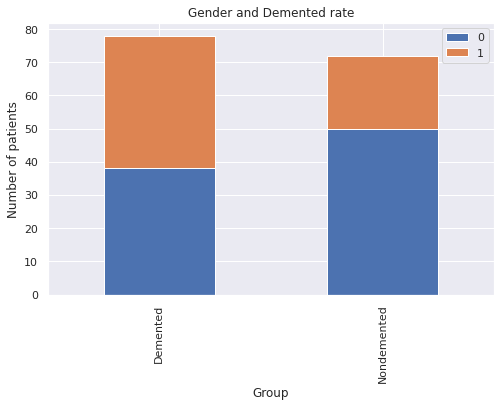

In [6]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

In [7]:
df.describe()

,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,150.000000,150.0,150.000000,150.000000,150.000000,142.000000,150.00000,150.000000,150.000000,150.000000,150.000000
mean,0.520000,0.0,0.413333,75.446667,14.533333,2.492958,27.56000,0.260000,1474.426667,0.736073,1.206333
std,0.501274,0.0,0.494081,7.545421,2.874714,1.128273,2.96847,0.326256,174.683889,0.036458,0.137864
min,0.000000,0.0,0.000000,60.000000,6.000000,1.000000,17.00000,0.000000,1123.000000,0.660000,0.883000
25%,0.000000,0.0,0.000000,70.000000,12.000000,2.000000,26.00000,0.000000,1347.250000,0.710000,1.121000
50%,1.000000,0.0,0.000000,75.000000,14.000000,2.000000,29.00000,0.000000,1453.500000,0.735000,1.207500
75%,1.000000,0.0,1.000000,80.000000,16.000000,3.000000,30.00000,0.500000,1565.250000,0.757750,1.302750
max,1.000000,0.0,1.000000,96.000000,23.000000,5.000000,30.00000,1.000000,1987.000000,0.837000,1.563000


73    12
78     9
77     8
76     8
70     8
80     8
66     7
71     7
81     7
69     7
82     6
74     6
75     6
68     5
88     4
79     4
89     4
86     4
61     4
67     3
65     3
83     3
72     3
87     2
84     2
60     2
92     1
85     1
90     1
64     1
93     1
63     1
96     1
62     1
Name: Age, dtype: int64

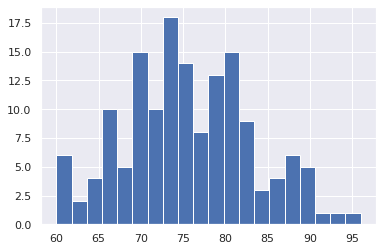

In [8]:
plt.hist(df.Age, 20);
df.Age.value_counts()

(15.3, 30.0)

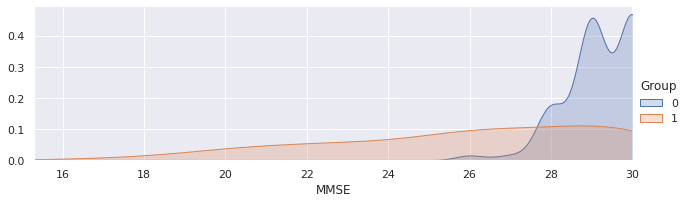

In [9]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30. 
#Min 17 ,MAX 30
facet= sns.FacetGrid(df, hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

In [13]:
import scipy

scipy.stats.mannwhitneyu(
     df[df.Group == 1].MMSE, df[df.Group != 1].MMSE, 
     use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=1207.0, pvalue=6.815967842889577e-10)

In [14]:
import scipy

scipy.stats.mannwhitneyu(
     df[df.Group == 1].EDUC, df[df.Group != 1].EDUC, 
     use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=2109.5, pvalue=0.007378635066374904)

In [16]:
import scipy

scipy.stats.mannwhitneyu(
     df[df.Group == 1].CDR, df[df.Group != 1].CDR, 
     use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=5148.0, pvalue=1.653739820997614e-23)

The chart shows Nondemented group got much more higher MMSE scores than Demented group.

(0.6, 0.9)

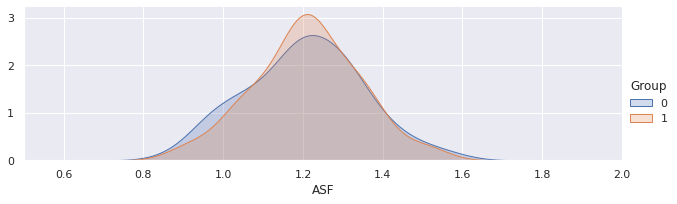

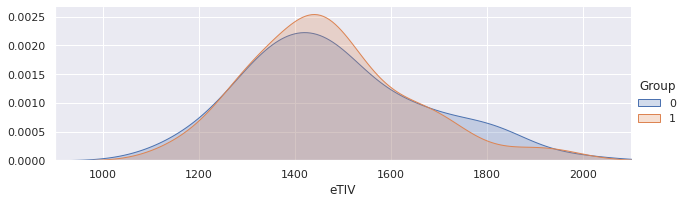

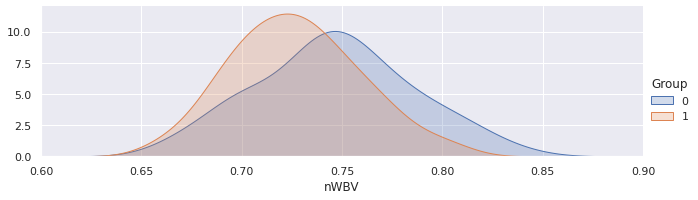

In [11]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients. We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.

In [1]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

## Intermediate Result Summary
1. Men are more likely with demented, an Alzheimer's Disease, than Women.
2. Demented patients were less educated in terms of years of education.
3. Nondemented group has higher brain volume than Demented group.
4. Higher concentration of 70-80 years old in Demented group than those in the nondemented patients.

## We can investigate the descripancy bw different brain measurments

In [12]:
df.head()

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,0,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,1,0,1,71,16,NaN,28.0,0.5,1357,0.748,1.293


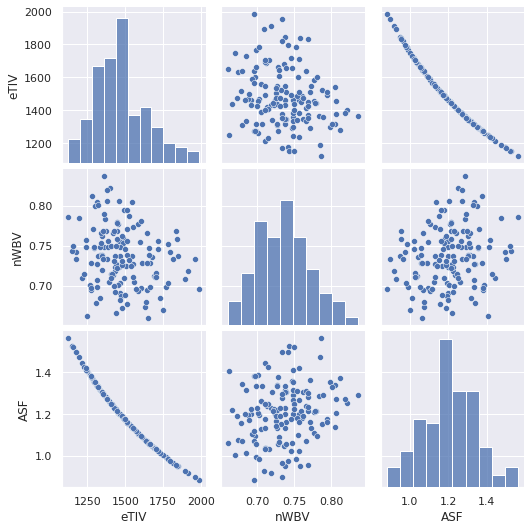

In [13]:
g = sns.pairplot(df[['eTIV', 'nWBV', 'ASF']])
plt.show()

On this plot, as well as from definition, eTIV & ASF variables are mutually determinable, thus bring no additional information (further only ASF will be used in analisys).

In [15]:
import scipy
scipy.stats.spearmanr(df['eTIV'], df['ASF'])

SpearmanrResult(correlation=-0.9999857764948965, pvalue=0.0)

# MR & PET Exploration 

In [14]:
import nibabel as nib
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.0001)
    face_color = [1, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [11]:
scan = nib.load('../data/OASIS/OAS30001_MR_d0129/anat1/NIFTI/sub-OAS30001_ses-d0129_acq-TSE_T2w.nii.gz')
scan = scan.get_data()

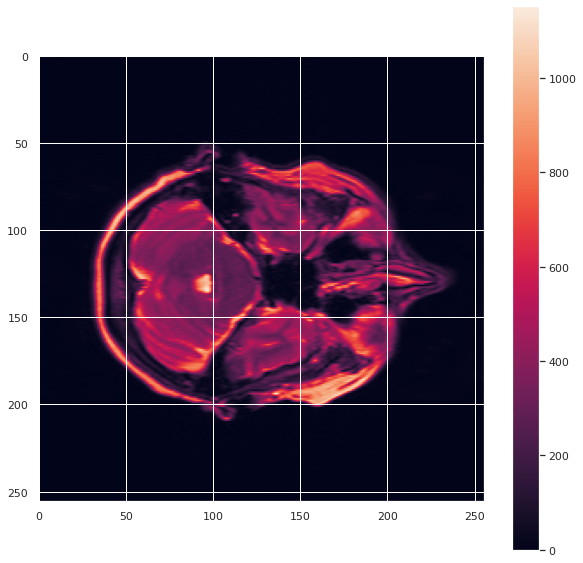

In [12]:
plt.figure(figsize=(10, 10))
a = plt.imshow(scan[..., 10])
plt.colorbar(a)

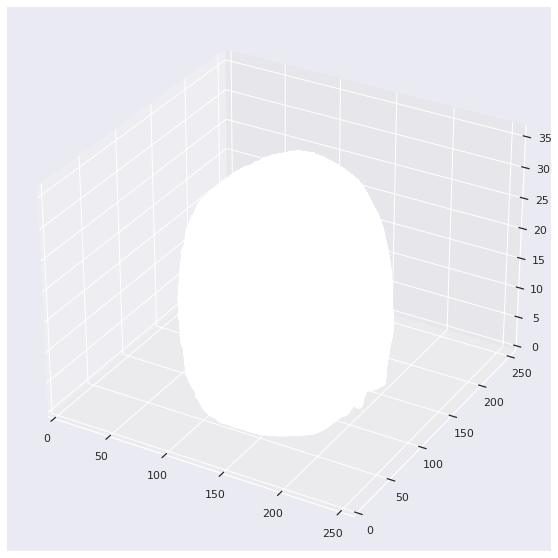

In [34]:
plot_3d(scan.T, 250)

Future work will be dedicated to analise and compare MR scans of statistical outliers